In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from tensorflow.keras.optimizers import Nadam
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
image_count = 0
labels = []
train_counts = []
for dirname in os.listdir('/content/drive/MyDrive/dataset/split-garbage-dataset/train'):
    labels.append(dirname)
    image_count = 0
    for img in os.listdir(os.path.join('/content/drive/MyDrive/dataset/split-garbage-dataset/train',dirname)):
        image_count +=1
    train_counts.append(image_count)

print(list(zip(train_counts,labels)))

[(287, 'cardboard'), (354, 'glass'), (286, 'metal'), (403, 'paper'), (347, 'plastic'), (91, 'trash')]


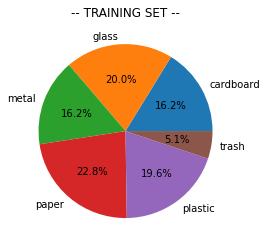

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=labels,
        autopct='%1.1f%%');
plt.title('-- TRAINING SET --');

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                  )

# Note that the validation data should not be augmented!
valid_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 8 using train_datagen generator
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/dataset/split-garbage-dataset/train',
                                                    batch_size =8,
                                                    class_mode = 'categorical', 
                                                    target_size = (150,150))     

# Flow validation images in batches of 4 using valid_datagen generator
validation_generator =  valid_datagen.flow_from_directory( '/content/drive/MyDrive/dataset/split-garbage-dataset/valid',
                                                          batch_size  = 4,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150,150))     

# Flow test images using test_datagen generator
test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/dataset/split-garbage-dataset/test',
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  target_size = (150,150),shuffle = False)     

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


In [ ]:
class_weights = []
total_samples = train_generator.samples              #1768
total_classes = len(train_generator.class_indices)   #6
for ele in train_counts:
    result = round(total_samples / (total_classes * ele),2)
    class_weights.append(result)
print(dict(zip(labels,class_weights)))

class_weights = dict(zip(train_generator.class_indices.values(),class_weights))

{'cardboard': 1.03, 'glass': 0.83, 'metal': 1.03, 'paper': 0.73, 'plastic': 0.85, 'trash': 3.24}


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

xception_model = keras.applications.xception.Xception(weights="imagenet",
                                                      include_top=False,
                                                      input_shape = (150,150,3))
avg = keras.layers.GlobalAveragePooling2D()(xception_model.output)
output = keras.layers.Dense(6, activation="softmax")(avg)
model = keras.models.Model(inputs=xception_model.input, outputs=output)

83689472/83683744 [==============================] - 2s 0us/step


In [ ]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer =optimizer ,loss = 'categorical_crossentropy',metrics =['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10,restore_best_weights = True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor = 0.7,patience = 2)
model_checkpoint =tf.keras.callbacks.ModelCheckpoint('GarbageClassifier_Xce.h5', save_best_only=True)

class CustomCallBack(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if(logs.get('accuracy')>0.9999):
                print("\nReached 99.99% accuracy so cancelling training!")
                self.model.stop_training = True
                
mycallback = CustomCallBack()

In [ ]:
history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples/train_generator.batch_size,
            epochs = 40,
            validation_data = validation_generator,
            validation_steps= validation_generator.samples/validation_generator.batch_size,
            class_weight = class_weights ,
            callbacks= [early_stopping_cb,model_checkpoint,lr_scheduler,mycallback],
            verbose=1)

Epoch 1/40
221/221 [==============================] - 53s 237ms/step - loss: 0.0558 - accuracy: 0.9791 - val_loss: 0.2975 - val_accuracy: 0.9177
Epoch 2/40
221/221 [==============================] - 52s 236ms/step - loss: 0.0494 - accuracy: 0.9853 - val_loss: 0.2951 - val_accuracy: 0.9085
Epoch 3/40
221/221 [==============================] - 52s 235ms/step - loss: 0.0613 - accuracy: 0.9813 - val_loss: 0.3336 - val_accuracy: 0.9055
Epoch 4/40
221/221 [==============================] - 52s 236ms/step - loss: 0.0588 - accuracy: 0.9813 - val_loss: 0.3304 - val_accuracy: 0.9207
Epoch 5/40
221/221 [==============================] - 52s 236ms/step - loss: 0.0492 - accuracy: 0.9842 - val_loss: 0.3274 - val_accuracy: 0.9238
Epoch 6/40
221/221 [==============================] - 52s 236ms/step - loss: 0.0615 - accuracy: 0.9802 - val_loss: 0.3043 - val_accuracy: 0.9238
Epoch 7/40
221/221 [==============================] - 52s 234ms/step - loss: 0.0575 - accuracy: 0.9808 - val_loss: 0.3098 - val_ac

No handles with labels found to put in legend.


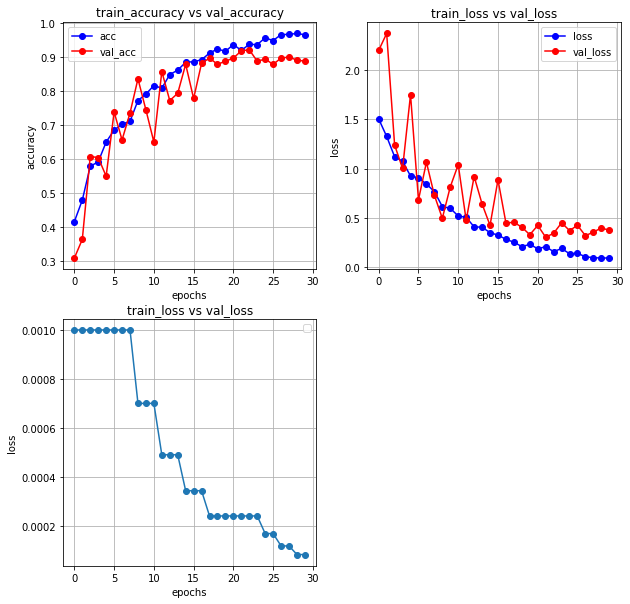

In [ ]:
fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo-', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'],'bo-', label = "loss")
plt.plot(history.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

plt.subplot(223)
plt.plot(history.epoch,history.history['lr'],'o-')
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

In [ ]:
model.evaluate(test_generator,batch_size = 1) 

431/431 [==============================] - 277s 642ms/step - loss: 0.3211 - accuracy: 0.9095


[0.321074515581131, 0.9095127582550049]

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        70
           1       0.97      0.88      0.92        82
           2       0.83      0.96      0.89        68
           3       0.95      0.92      0.93       108
           4       0.93      0.86      0.90        74
           5       0.69      0.93      0.79        29

    accuracy                           0.91       431
   macro avg       0.89      0.91      0.90       431
weighted avg       0.92      0.91      0.91       431



Text(0.5, 1.0, 'Confusion matrix of model')

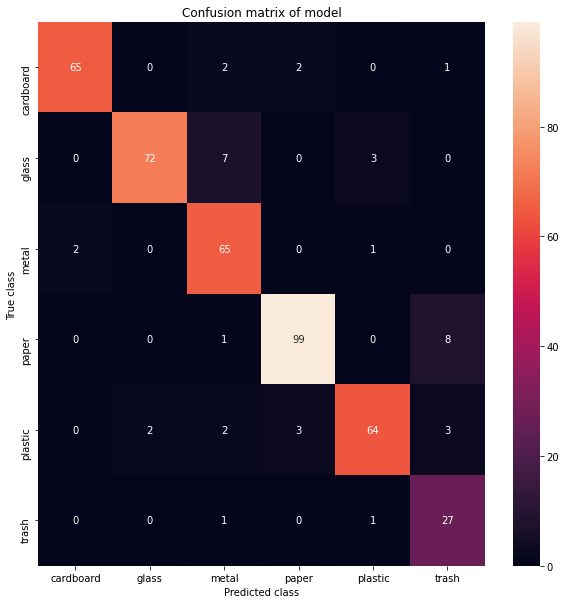

In [ ]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred))
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(), annot=True, fmt='d', color='red')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')